# Read multiple sweeps to create a volume scan with xradar and datatree
This example show how create a volume scan using multiple sweep files from AWS.
## Imports

In [1]:
import pyart
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import numpy as np
import cartopy.crs as ccrs
from pandas import to_datetime
import matplotlib.pyplot as plt
from botocore.client import Config
from datetime import datetime
from matplotlib import pyplot
from datatree import DataTree
# pyplot.style.use('dark_background')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Access radar data from Colombian radar network on AWS
Access data from IDEAM bucket on AWS. Detailed information can be found [here](https://github.com/aladinor/notebooks/blob/origin/master/IDEAM_Radar_from_AWS.ipynb) 

In [2]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'

In [3]:
date_query = datetime(2023, 2, 10)
radar_name = "Guaviare" 
query = create_query(date=date_query, radar_site=radar_name)

In [4]:
str_bucket = 's3://s3-radaresideam/'
s3 = boto3.resource('s3',
                    config=Config(signature_version=botocore.UNSIGNED, 
                                  user_agent_extra='Resource'))

bucket = s3.Bucket('s3-radaresideam')

radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]
radar_files[:5]

['s3://s3-radaresideam/l2_data/2023/02/10/Guaviare/GUA230210000057.RAW3S7G',
 's3://s3-radaresideam/l2_data/2023/02/10/Guaviare/GUA230210000202.RAW3S7L',
 's3://s3-radaresideam/l2_data/2023/02/10/Guaviare/GUA230210000333.RAW3S7P',
 's3://s3-radaresideam/l2_data/2023/02/10/Guaviare/GUA230210000410.RAW3S7T',
 's3://s3-radaresideam/l2_data/2023/02/10/Guaviare/GUA230210000446.RAW3S7W']

## Let's check elevation at each files using PyArt

IDEAM radar network operates with a volume scan every five minutes. Each volume scan has four different tasks 
* *SURVP* "super resolution" sweep at the lowest elevation angle, usually 0.5 deg,  with 720 degrees in azimuth (every 0.5 deg)
* *PRECA* task with 1.5, 2.4, 3.0, and 5.0 elevation angles and shorter range than *SURP*
* *PRECB* task with 6.4 and 8.0 elevation angles and shorter range than previous task
* *PRECC* task with 10.0, 12.5, and 15.0 with shorter range than previous task as well

In [5]:
for i in radar_files[:5]:
    of = pyart.io.prepare_for_read(i, storage_options={'anon': True})
    with of as f:
        radar = pyart.io.read(f)
        print(f"radar elevation {radar.fixed_angle['data']}")
        print(f" task name : {radar.metadata['sigmet_task_name']}")
        print('--------------------------------------------------------')
        f.close()

/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/pyart/io/sigmet.py:146: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


radar elevation [0.49987793]
 task name : b'SURVP       '
--------------------------------------------------------
radar elevation [1.4996338 2.4005127 3.0981445 5.0976562]
 task name : b'PRECA       '
--------------------------------------------------------
radar elevation [6.399536 7.998047]
 task name : b'PRECB       '
--------------------------------------------------------
radar elevation [ 9.997559 12.502441 15.001831]
 task name : b'PRECC       '
--------------------------------------------------------
radar elevation [0.49987793]
 task name : b'SURVP       '
--------------------------------------------------------


## Create a  sigle volume scan using four taks 
Let's use the first four files, tasks *SURVP*, *PRECA*, *PRECB*, *PRECC*, to create a single volume scan 

In [6]:
# List of task files
task_files = [fsspec.open_local(f'simplecache::{i}', s3={'anon': True}, filecache={'cache_storage': '.'}) 
             for i in radar_files[:4]]

To create a single vcp object with all sweeps we need to create a datatree object with all tasks and its own sweeps

In [28]:
# list of xradar datatrees
ls_dt = [xd.io.open_iris_datatree(i).xradar.georeference() for i in task_files]

Now that we have each task as a Datatree we can create our Datatree object with all task

In [29]:
vcp_dt = DataTree(name='root', 
                  children={
                      "SURVP": ls_dt[0], 
                      "PRECA": ls_dt[1], 
                      "PRECB": ls_dt[2], 
                      "PRECC": ls_dt[3]})

In [30]:
vcp_dt

DataTree('root', parent=None)
├── DataTree('SURVP')
│   │   Dimensions:              ()
│   │   Data variables:
│   │       volume_number        int64 0
│   │       platform_type        <U5 'fixed'
│   │       instrument_type      <U5 'radar'
│   │       time_coverage_start  <U20 '2023-02-10T00:00:58Z'
│   │       time_coverage_end    <U20 '2023-02-10T00:01:59Z'
│   │       longitude            float64 -72.63
│   │       altitude             float64 240.0
│   │       latitude             float64 2.534
│   │   Attributes:
│   │       Conventions:      None
│   │       version:          None
│   │       title:            None
│   │       institution:      None
│   │       references:       None
│   │       source:           None
│   │       history:          None
│   │       comment:          im/exported using xradar
│   │       instrument_name:  None
│   └── DataTree('sweep_0')
│           Dimensions:            (azimuth: 720, range: 994)
│           Coordinates:
│             * azimuth            (azimuth) float64 0.02747 0.5191 1.033 ... 359.0 359.5
│               elevation          (azimuth) float64 0.4834 0.4834 0.4834 ... 0.4834 0.4834
│               time               (azimuth) datetime64[ns] 2023-02-10T00:01:22.865000 .....
│             * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│               longitude          float64 -72.63
│               latitude           float64 2.534
│               altitude           float64 240.0
│               spatial_ref        int64 0
│               x                  (azimuth, range) float64 0.4793 0.6231 ... -2.477e+03
│               y                  (azimuth, range) float64 999.9 1.3e+03 ... 2.987e+05
│               z                  (azimuth, range) float64 248.5 251.1 ... 8.011e+03
│           Data variables: (12/17)
│               DBTH               (azimuth, range) float32 ...
│               DBZH               (azimuth, range) float32 ...
│               VRADH              (azimuth, range) float32 ...
│               WRADH              (azimuth, range) float32 ...
│               ZDR                (azimuth, range) float32 ...
│               KDP                (azimuth, range) float32 ...
│               ...                 ...
│               DB_DBZE8           (azimuth, range) int16 ...
│               sweep_mode         <U20 ...
│               sweep_number       int64 ...
│               prt_mode           <U7 ...
│               follow_mode        <U7 ...
│               sweep_fixed_angle  float64 ...
├── DataTree('PRECA')
│   │   Dimensions:              ()
│   │   Data variables:
│   │       volume_number        int64 0
│   │       platform_type        <U5 'fixed'
│   │       instrument_type      <U5 'radar'
│   │       time_coverage_start  <U20 '2023-02-10T00:02:03Z'
│   │       time_coverage_end    <U20 '2023-02-10T00:03:31Z'
│   │       longitude            float64 -72.63
│   │       altitude             float64 240.0
│   │       latitude             float64 2.534
│   │   Attributes:
│   │       Conventions:      None
│   │       version:          None
│   │       title:            None
│   │       institution:      None
│   │       references:       None
│   │       source:           None
│   │       history:          None
│   │       comment:          im/exported using xradar
│   │       instrument_name:  None
│   ├── DataTree('sweep_0')
│   │       Dimensions:            (azimuth: 360, range: 747)
│   │       Coordinates:
│   │         * azimuth            (azimuth) float64 0.002747 0.9915 2.013 ... 358.1 359.1
│   │           elevation          (azimuth) float64 1.472 1.472 1.472 ... 1.472 1.472 1.472
│   │           time               (azimuth) datetime64[ns] 2023-02-10T00:02:09.057000 .....
│   │         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │           longitude          float64 -72.63
│   │           latitude           float64 2.534
│   │           altitude           float64 240.0


## Creating a PPI plot from Datatree object

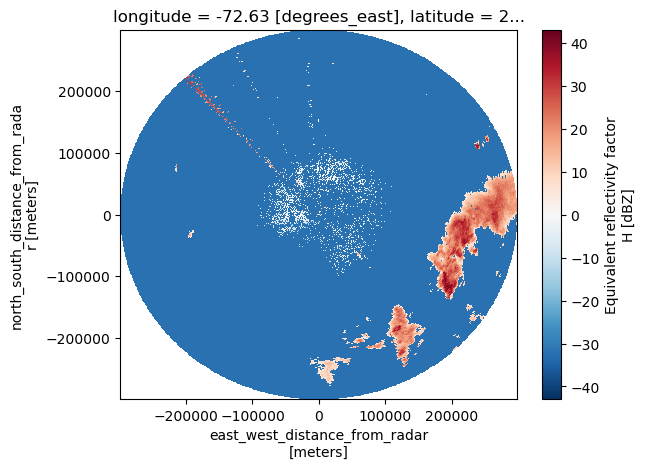

In [32]:
vcp_dt['SURVP']['sweep_0'].DBZH.plot(x='x', y='y')

## Storaging data in Analysis-ready cloud format

In [36]:
_ = vcp_dt.to_zarr('./vcp_test.zarr')

/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decod

In [20]:
! ls vcp_test.zarr/PRECA/sweep_0/DBZH/

0.0  0.1  1.0  1.1
